---
title: SpatioTemporal Field - T2M - Stationary - Analysis
subject: AEMET T2M
short_title: 2b - Analysis Station
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(num_devices)

In [19]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
import arviz as az

from st_evt import CANDIDATE_STATIONS
from st_evt.utils import ExperimentPath
from st_evt.viz import (
    plot_scatter_ts,
    plot_histogram,
    plot_density,
    plot_return_level_gevd_manual_unc_multiple,
    plot_periods,
    plot_periods_diff
)
from st_evt.extremes import estimate_return_level_gevd, calculate_exceedence_probs

from omegaconf import OmegaConf

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [3]:
config_file_name = "/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/config/config.json"
config = OmegaConf.load(config_file_name)

config

{'experiment_name': 'walkthrough/ts_t2m_spain/stationary_iid', 'dataset': 'aemet', 'station_id': 'spain-redfeten', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_spain_stationary.yaml', 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr', 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data', 'clean_data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/clean_data.nc', 'mcmc_results_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary

### Data

In [5]:
root_path = Path(config["exp_path"])
clean_data_path = Path(config["clean_data_path"])
covariate_data_path = Path(config["covariate_path"])
results_data_path = Path(config["mcmc_results_path"])


exp_file_config = ExperimentPath(root_dir=root_path)
figures_path = exp_file_config.figures_results_dir
data_path = exp_file_config.data_dir

In [7]:
with xr.open_dataset(clean_data_path, engine="netcdf4") as f:
    ds_station = f.load()
ds_station

<xarray.Dataset> Size: 68kB
Dimensions:          (gmst: 60, station_id: 154, quantile: 5)
Coordinates:
    alt              (station_id) float32 616B 32.0 118.0 71.0 ... 620.0 10.0
    lat              (station_id) float32 616B 40.96 41.15 41.19 ... 28.49 28.13
    lon              (station_id) float32 616B 0.87 1.108 ... -16.32 -15.42
    red_feten_mask   (station_id) uint8 154B 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id       (station_id) <U5 3kB '0002I' '0016B' ... 'C447B' 'C659T'
    station_name     (station_id) <U40 25kB 'vandellòs' ... 'las palmas de g....
    time             (gmst) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
  * gmst             (gmst) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196
  * quantile         (quantile) float64 40B 0.9 0.95 0.98 0.99 0.995
Data variables:
    t2m_max_bm_year  (gmst, station_id) float32 37kB 32.2 33.32 ... 40.31 28.28
    threshold        (quantile) float64 40B 35.1 36.7 38.4 39.48 40.37

### MCMC Results

In [9]:

az_ds = az.from_netcdf(results_data_path)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [13]:
candidate_station = CANDIDATE_STATIONS["valencia"]
candidate_station

az_ds = az_ds.sel(station_id = candidate_station[0])

In [16]:
sub_figures_path = figures_path.joinpath(str(candidate_station[0]))
sub_figures_path.mkdir(parents=True, exist_ok=True)

## Posterior Calculations

### Return Level

In [20]:



RETURN_PERIODS_GEVD = np.logspace(0.001, 4, 100)

fn_gevd = jax.jit(estimate_return_level_gevd)

def calculate_return_period(return_periods, location, scale, shape):
    rl = jax.vmap(fn_gevd, in_axes=(0,None,None,None))(return_periods, location, scale, shape)
    return rl

In [21]:
az_ds.posterior["return_level_100"] = xr.apply_ufunc(
    calculate_return_period,
    [100],
    az_ds.posterior.location,
    az_ds.posterior.scale,
    az_ds.posterior.concentration,
    input_core_dims=[[""], ["draw"], ["draw"], ["draw"]],
    output_core_dims=[["draw"]],
    vectorize=True
)

az_ds.posterior["return_level"] = xr.apply_ufunc(
    calculate_return_period,
    RETURN_PERIODS_GEVD,
    az_ds.posterior.location,
    az_ds.posterior.scale,
    az_ds.posterior.concentration,
    input_core_dims=[["return_period"], ["draw"], ["draw"], ["draw"]],
    output_core_dims=[["return_period", "draw"]],
    vectorize=True
)


az_ds.posterior_predictive["return_level_100"] = xr.apply_ufunc(
    calculate_return_period,
    [100],
    az_ds.posterior_predictive.location,
    az_ds.posterior_predictive.scale,
    az_ds.posterior_predictive.concentration,
    input_core_dims=[[""], ["draw"], ["draw"], ["draw"]],
    output_core_dims=[["draw"]],
    vectorize=True
)

az_ds.posterior_predictive["return_level"] = xr.apply_ufunc(
    calculate_return_period,
    RETURN_PERIODS_GEVD,
    az_ds.posterior_predictive.location,
    az_ds.posterior_predictive.scale,
    az_ds.posterior_predictive.concentration,
    input_core_dims=[["return_period"], ["draw"], ["draw"], ["draw"]],
    output_core_dims=[["return_period", "draw"]],
    vectorize=True
)
az_ds = az_ds.assign_coords({"return_period": RETURN_PERIODS_GEVD})
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [12]:
from dynev4eo._src.viz.params import plot_posterior_param_trace, plot_posterior_params_joint

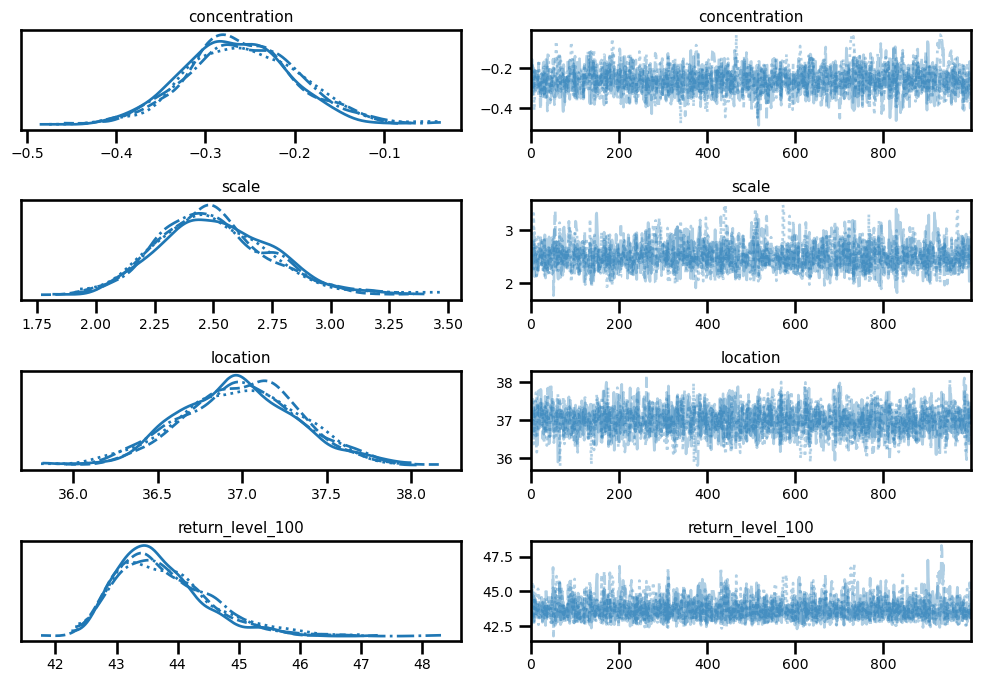

In [23]:
variables = [
    "concentration",
    "scale",
    "location",
    "return_level_100", 
    # "sigma", "rate",
    # "return_level_100",
    ]





fig = az.plot_trace(
    az_ds.posterior, 
    var_names=variables,
    figsize=(10, 7)
);
plt.savefig(sub_figures_path.joinpath("trace.png"))
plt.gcf().set_dpi(100)
plt.tight_layout()
plt.show()

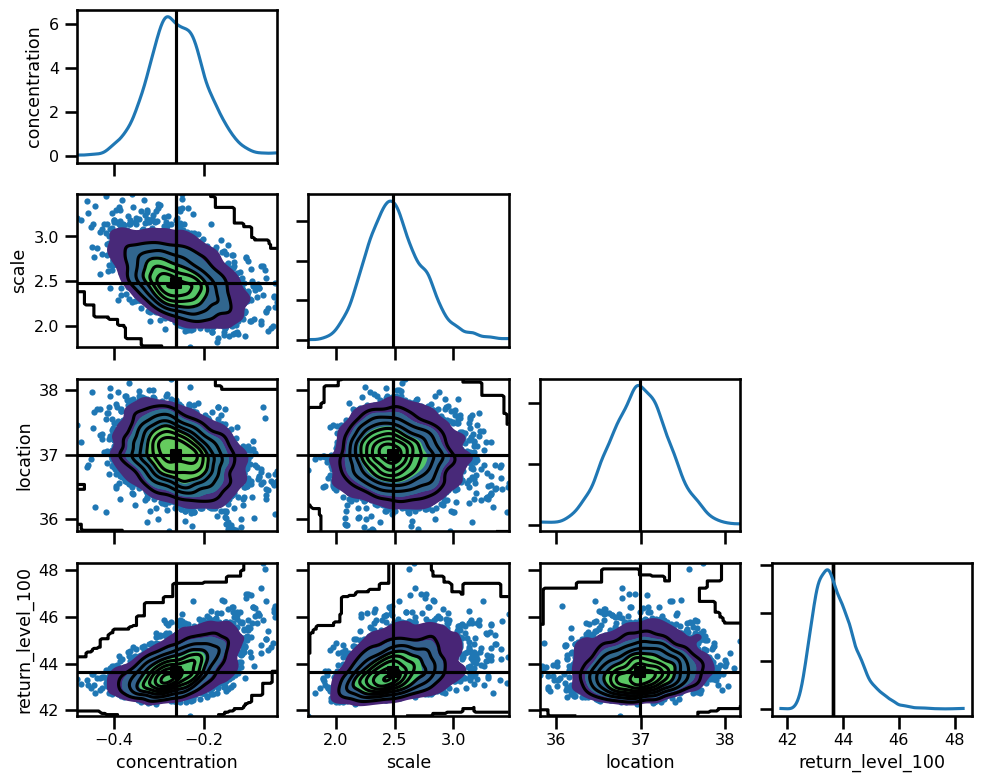

In [24]:
fig = az.plot_pair(
    az_ds.posterior,
    # group="posterior",
    var_names=variables,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    # coords=coords,
    point_estimate="median",
    figsize=(10, 8),
)
plt.tight_layout()
plt.savefig(figures_path.joinpath("params_joint.png"))
plt.gcf().set_dpi(100)
plt.show()

### QQ-Plot

In [38]:
from st_evt.viz import plot_qq_plot_gevd_manual

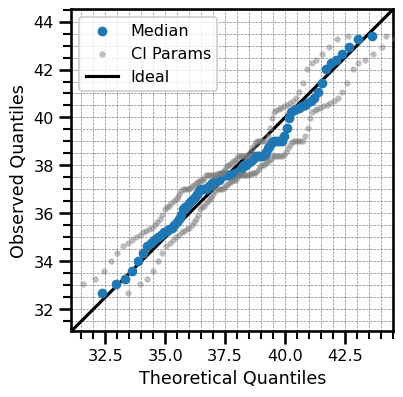

In [39]:
# extract parameters
idata = az.extract(az_ds, group="posterior", num_samples=2_000)

# extract observations
y_obs = az_ds.observed_data.obs.dropna(dim="time")


fig, ax = plot_qq_plot_gevd_manual(
    location=idata.location, 
    scale=idata.scale, 
    concentration=idata.concentration, 
    observations=y_obs.values.ravel(),
    figures_save_dir=None)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("qq_plot.png"))
plt.show()

### Prediction Plot

In [40]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
# error = 

In [41]:
idata = az.extract(az_ds, group="posterior_predictive", num_samples=10_000)

y_obs = az_ds.observed_data.obs
y_pred = idata.obs

In [42]:
error = xr.apply_ufunc(
    root_mean_squared_error,
    y_obs,
    y_pred,
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[]],
    vectorize=True
)

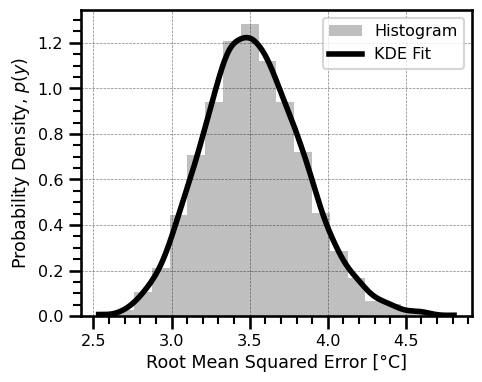

In [43]:
fig, ax = plot_density(error)
ax.set(
    title="",
    xlabel="Root Mean Squared Error [°C]"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()

# fig.savefig(figures_path.joinpath("hist_bm.png"))
plt.show()

In [44]:
error = xr.apply_ufunc(
    mean_absolute_error,
    y_obs,
    y_pred,
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[]],
    vectorize=True
)

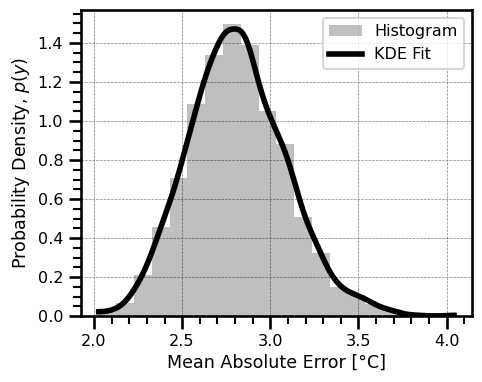

In [45]:
fig, ax = plot_density(error)
ax.set(
    title="",
    xlabel="Mean Absolute Error [°C]"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
# fig.savefig(figures_path.joinpath("hist_bm.png"))
plt.show()

### Return Periods

In [48]:
from st_evt.viz import plot_return_level_gevd_manual_unc, plot_return_level_hist_manual_unc
from st_evt.extremes import estimate_return_level_gevd

In [49]:
from functools import partial
return_periods = np.logspace(0.001, 3, 100)


return_level = idata["return_level"].T
return_periods = idata.return_period
y = az_ds.observed_data.obs.dropna(dim="time").squeeze()

In [53]:
ylabel = r"2m Max Temperature [°C]"

In [54]:
return_level.shape, return_periods.shape, y.shape

((4000, 100), (100,), (60,))

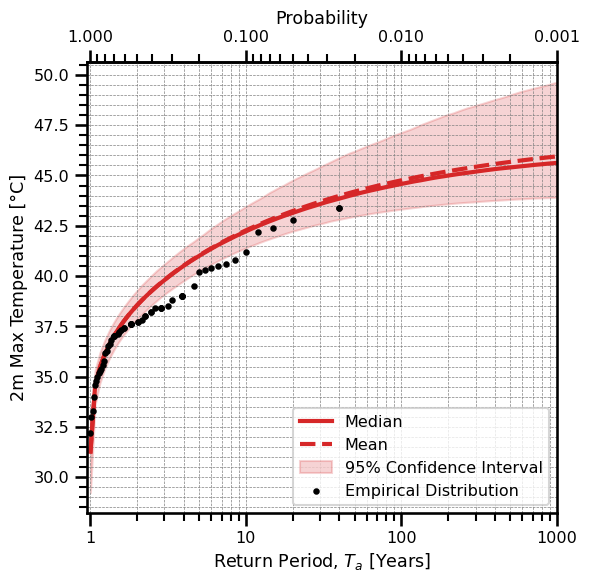

In [61]:
fig, ax = plot_return_level_gevd_manual_unc(
    return_level.squeeze(), return_periods, y.squeeze(), None
)
ax.set(
    ylabel=ylabel,
    # xlabel="Time [Years]"
)
fig.set(
    dpi=100,
    size_inches=(6,6)
)
fig.savefig(figures_path.joinpath("returns_vs_obs"))
plt.show()

#### 100-Year Return Period

In [56]:
from functools import partial
return_periods = np.logspace(0.001, 3, 100)

return_level_100 = idata.return_level_100
return_level_100

<xarray.DataArray 'return_level_100' (sample: 4000)> Size: 16kB
array([43.52285 , 43.47651 , 43.471104, ..., 43.089   , 42.975525,
       42.769493], dtype=float32)
Coordinates:
    alt             float32 4B 56.0
    lat             float32 4B 39.48
    lon             float32 4B -0.476
    red_feten_mask  uint8 1B 1
    station_id      <U5 20B '8414A'
    station_name    <U40 160B 'valencia, aeropuerto'
  * sample          (sample) object 32kB MultiIndex
  * chain           (sample) int64 32kB 2 0 1 3 0 3 0 2 0 ... 1 0 2 3 1 2 1 1 0
  * draw            (sample) int64 32kB 652 581 197 550 314 ... 507 532 315 862

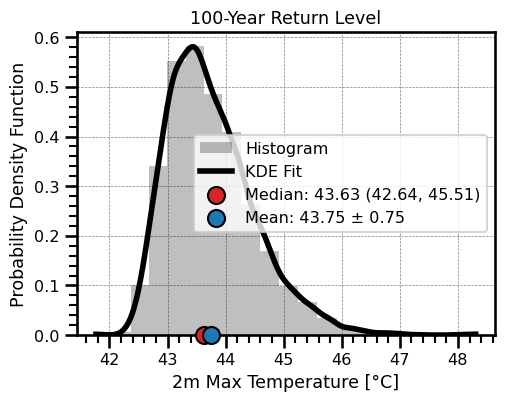

In [58]:
hist, bins = np.histogram(return_level_100.values.ravel(), bins=20)
bins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

fig, ax = plot_return_level_hist_manual_unc(return_level_100, None, bins=bins)

ax.set(
    xlabel="2m Max Temperature [°C]",
    title="100-Year Return Level"
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
fig.savefig(figures_path.joinpath("returns100_gmst_density"))
plt.show()